# Capítulo Técnico
## 2. Modelo de predicciones

In [1]:
# Dado que nuestra variable objetivo es binaria, tratamos con un problema que se puede
# solucionar mediante un sistema de clasificación.
# Para este caso, la variable objetivo es 'y' y trabajaremos con la libreria sklearn
# esta librería contiene herramientas para trabajar con machine learning, donde se incluyen
# algoritmos de clasificación

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./datos/bank-full.csv', sep=';')

In [4]:
# selección de variables numéricas y categóricas para uso posterior en el tratamiento de datos
variables_numericas = df.select_dtypes(include=['int64'])
variables_categoricas = df.select_dtypes(exclude=['int64'])

In [5]:
# Antes de proponer un modelo, analicemos qué variables pueden ser más importantes a la
# hora de desarrollar nuestro modelo, para esto miremos las distribuciones de las variables
# con respecto a si el cliente a suscrito (yes) o no (no) un depósito según nuestra variable objetivo y
# Previo a visualizar dichas distribuciones, se aplica un método de tratamiento de datos de valores atípicos,
# esto dado que en el apartado inicial de análisis se observo una variedad alta de valores atípicos y
# queremos una visualización clara de las distribuciones, en este caso aplicamos el método inter cuartil
# en el cual valores atípicos en los extremos son aterrizados al cuartil más cercano.

# cálculo del IQR
Q1 = df[variables_numericas.columns].quantile(0.25)
Q3 = df[variables_numericas.columns].quantile(0.75)
IQR = Q3 - Q1

# límites para los valores atípicos
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar y tratar los valores atípicos
for col in df[variables_numericas.columns].columns:
    df.loc[df[col] < limite_inferior[col], col] = limite_inferior[col]
    df.loc[df[col] > limite_superior[col], col] = limite_superior[col]

C:\Users\diego\AppData\Local\Temp\ipykernel_11700\3745163370.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] < limite_inferior[col], col] = limite_inferior[col]
C:\Users\diego\AppData\Local\Temp\ipykernel_11700\3745163370.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-11.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] < limite_inferior[col], col] = limite_inferior[col]


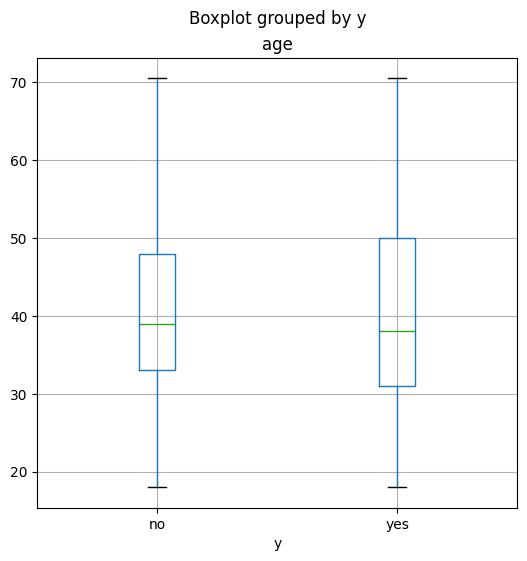

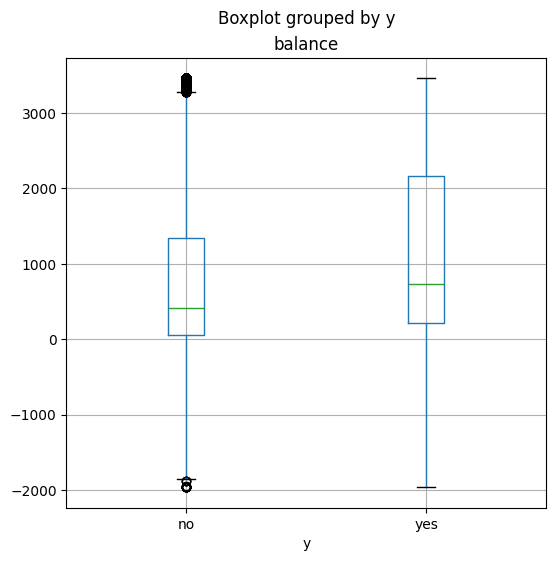

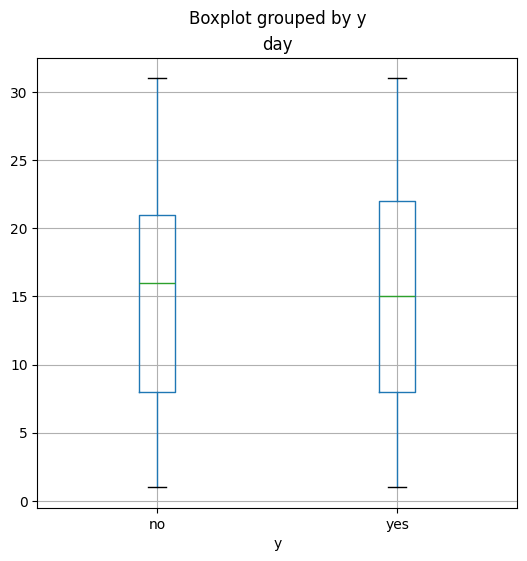

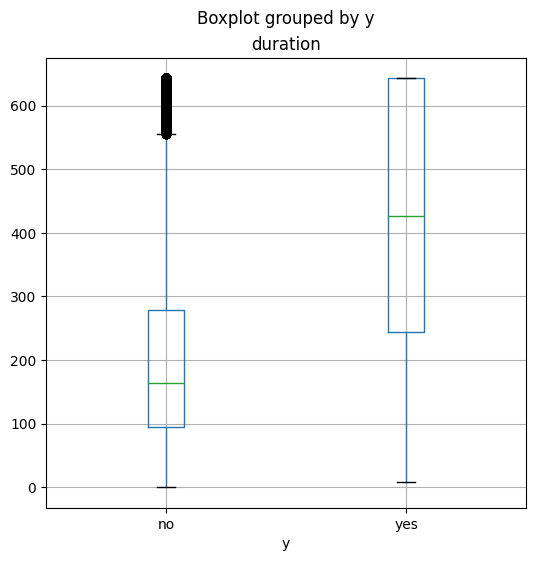

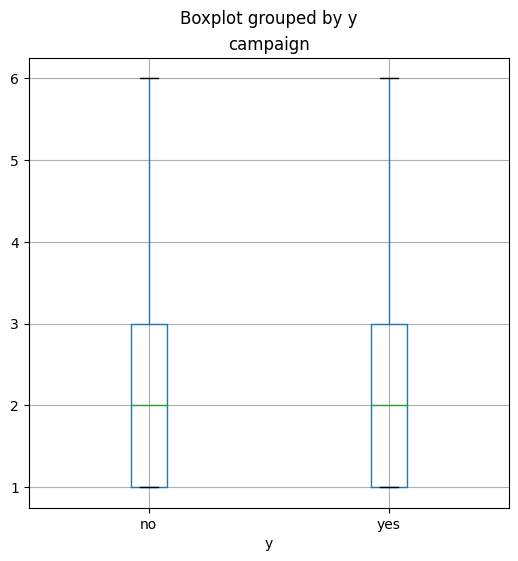

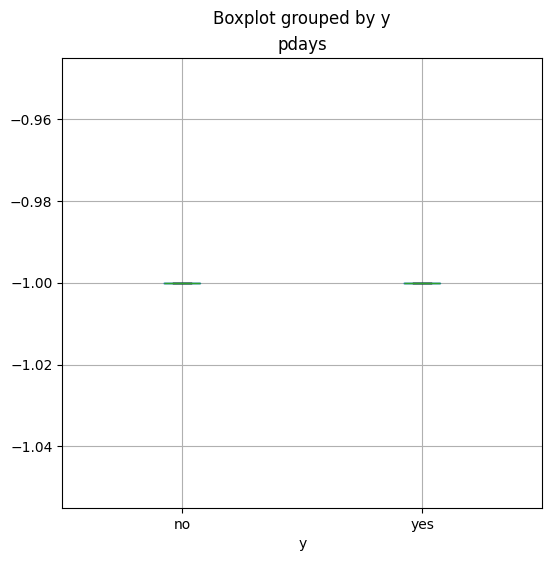

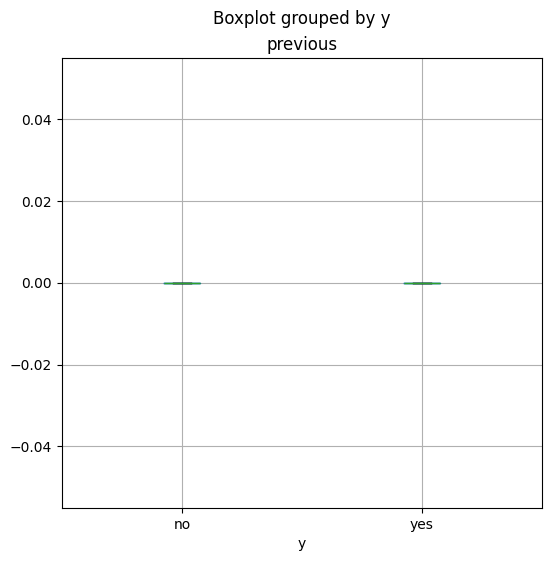

In [6]:
# Según las siguientes distribuciones, hay una diferencia notable entre personas que si o no se 
# suscriben para ciertas variables, es el caso de balance y duración, es decir que estas variables
# son las que más van a impactar a la hora de buscar predecir si un cliente acepta o no una suscripción
features = variables_numericas.columns
for col in features:
    df.boxplot(column=col, by='y', figsize=(6,6))
    plt.title(col)
plt.show()

In [7]:
# Para entrenar el modelo, también hacemos un tratamiento a las variables categóricas, estas les
# aplicamos una encodización OneHotEncoding.
# Para el OneHotEncoding utilizamos get_dummies de pandas

df = pd.get_dummies(df, columns=variables_categoricas.drop('y', axis=1).columns)
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

In [8]:
# El OneHotEncoding crea nuevas columnas que contienen información de cada categoria dentro de
# las columnas categóricas iniciales
df.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58.0,2143,5.0,261,1,-1,0,0,False,False,...,False,False,True,False,False,False,False,False,False,True
1,44.0,29,5.0,151,1,-1,0,0,False,False,...,False,False,True,False,False,False,False,False,False,True
2,33.0,2,5.0,76,1,-1,0,0,False,False,...,False,False,True,False,False,False,False,False,False,True
3,47.0,1506,5.0,92,1,-1,0,0,False,True,...,False,False,True,False,False,False,False,False,False,True
4,33.0,1,5.0,198,1,-1,0,0,False,False,...,False,False,True,False,False,False,False,False,False,True


In [9]:
# Ahora, separaramos los datos de entrenamiento y test del modelo, en una distribución de
# 70% train y 30% test. Podemos también utilizar el dataset bank.csv que contiene un 10% de los datos.
# Para este caso usaremos la separación con el dataset total de igual forma en como se creo bank.csv
# pero en lugar de un 10% sacaremos un 30%

# Empezamos separando las variables de la columna objetivo
features = df.drop('y', axis=1).columns
label = 'y'
X, y = df[features].values, df[label].values

In [10]:
# Antes de continuar, si analizamos la columna objetivo que queremos determinar con un modelo,
# encontramos que esta se encuentra desbalanceada como se ve acontinuación
df['y'].value_counts()

# Para solucionar este problema, aplicamos un método de balanceo de datos, dado que con esta disparidad
# el modelo solo va a tender a responder con 0 (no) dado que hay más datos de esta categoría.
# Utilizamos la librería  imblearn para ML.

y
0    39922
1     5289
Name: count, dtype: int64

In [11]:
from imblearn.over_sampling import SMOTE

# Crear una instancia de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Aplicar SMOTE para generar datos sintéticos y balancear las clases
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos balanceados (opcional)
df = pd.DataFrame(X_resampled, columns=[f'feature_{i}' for i in range(X_resampled.shape[1])])
df['y'] = y_resampled

In [12]:
# Ahora los datos están balanceados
df['y'].value_counts()

y
0    39922
1    39922
Name: count, dtype: int64

In [16]:
# Ahora si separamos los datos 70-30 entrenamiento y test
from sklearn.model_selection import train_test_split

features = df.drop('y', axis=1).columns
label = 'y'
X, y = df[features].values, df[label].values

# Separación de datos 70-30% de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Datos de entrenamiento: {}\nDatos de prueba: {}'.format(X_train.shape[0], X_test.shape[0]))

Datos de entrenamiento: 55890
Datos de prueba: 23954


In [17]:
# Ahora entrenamos el modelo
# Train the model
from sklearn.linear_model import LogisticRegression

# Entrenamos con los hiperparámetros por defecto
# y con una taza de recularización del 0.01 recomendada por la literatura, es decir
# la rapidez con que se ajusta un modelo a los datos, no queremos que sea muy alta porque
# puede generarse un sobreajuste de los datos
model = LogisticRegression(C=1/0.01, solver="liblinear").fit(X_train, y_train)

In [18]:
# Creado nuestro modelo procedemos a evaluarlo, para este caso utilizaremos las métricas técnicas
# Accuracy, Precision, Recall y curva ROC
# Por la parte de negocio, podemos hacer un análisis posterior a la implementación del modelo,
# en el cual recopilemos los datos de los clientes predichos a suscribirse y los que realmente
# lo hicieron.
# En caso de no poder esperar a probar el modelo, se crea un id para cada registro en la muestra original,
# luego se hace una extracción de datos iniciales y se comparan datos predichos con datos originales,
# comparando los ids, entonces si se analiza que dentro de las variables (feature) contenidas en los clientes
# que se predijo que si se suscribiría se ve un comportamiento acorde a un cliente que realmente lo haría
# podemos decir que el modelo realiza las predicciones bien. Las features mencionadas al inicio 
# (balance, duracion) serían variables decisibas en esta métrica de negocio.
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Se hacen las predicciones sobre los datos test
predicciones = model.predict(X_test)

# Calcular el accuracy
print('Accuracy: ', accuracy_score(y_test, predicciones))

# Calcular la precisión
print('Precision:', precision_score(y_test, predicciones))

# Calcular el recall
print('Recall: ', recall_score(y_test, predicciones))

Accuracy:  0.848584787509393
Precision: 0.8426713758227645
Recall:  0.8629675297986026


In [ ]:
# Finalmente, hemos obtenido una serie de métricas técnicas con valores por encima del 80 porciento, 
# esto quiere decir que nuestro modelo es fiable un valor superior al 80%, es un buen indicativo de que 
# podemos confiar en el algoritmo desde el campo técnico.

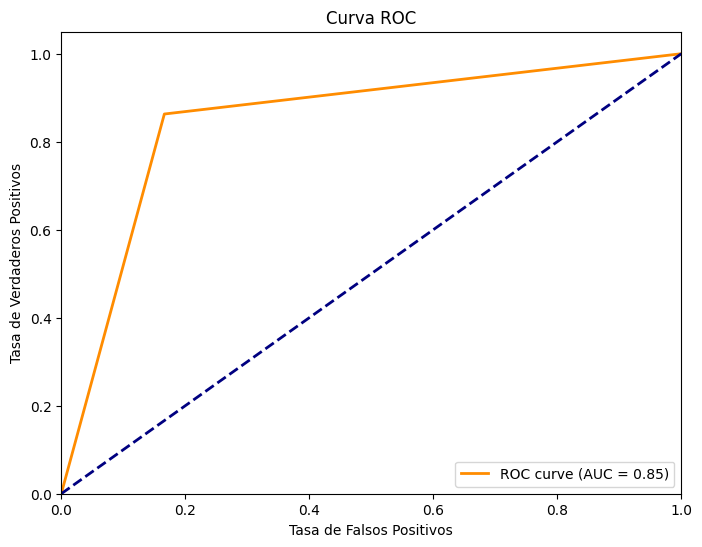

In [19]:
# Si graficamos la curva ROC, vemos que esta sobrepasa la gráfica lineal que sale del origen lo que
# significa que nuestro modelo es altamente confiable, para hacernos una idea si nuestra gráfica
# quedara al mismo nivel de la linea cortada sería equivalente a lanzar una moneda al aire para
# saber si un cliente se suscribe o no, lo cual es altamente inexacto

from sklearn.metrics import roc_curve, roc_auc_score

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, predicciones)

# Calcular el área bajo la curva ROC (AUC)
auc = roc_auc_score(y_test, predicciones)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Apuntes finales
# El análisis de datos y el modelo fueron desarrollados de forma experimental en notebooks
# de Jupyter, esto con el fin de tener una interacción más rápida entre prueba y error.
# En un ambiente de desarrollo o producción, se llevaría acabo el desarrollo en scripts de Python
# en donde se elige un paradigma de desarrollo para distribuir los distintos módulos de extracción,
# tratamiento, entrenamiento e inferencia.

# De igual forma, el análisis de los datos puede profundizarse continuando la comparativa entre variables
# de clientes y variables externas, a su vez se pueden desarrollar variables derivadas de las variables
# iniciales.
# Por otra parte, las métricas deben seguirse analizando con distintas iteraciones para determinar si 
# cambian o no a medida que se añaden nuevos datos o se corren con distintos parámetros, esto con
# el fin de mejorar las métricas y ver su estabilidad en el tiempo.